In [11]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
import seaborn as sns
import os, re, math
import matplotlib.pyplot as plt
#%matplotlib inline

sns.set(color_codes=True)

CLASS_LABELS = ['slowest', 'slow', 'middle', 'fast', 'fastest']
DATA_SET_DIR = '/Users/emmanueldollinger/PycharmProjects/prediction_by_k/DATA/FEATURE_ANALYSIS/'
GENOMIC_FEATURES_DIR = '/Users/emmanueldollinger/PycharmProjects/prediction_by_k/DATA/Genomic_Features/'

ORIGIN_DATA_DIR = os.path.join(DATA_SET_DIR, 'ORIGIN_DATA')
CLASSIFIED_DATA_DIR = os.path.join(DATA_SET_DIR, 'CLASSIFIED_DATA')
ChrmoHMM_DIR = os.path.join(DATA_SET_DIR, 'ChrmoHMM_INTERSECTED')
HISTONE_DIR = os.path.join(DATA_SET_DIR, 'HISTONE_INTERSECTED')
K_METHY_DIR = os.path.join(DATA_SET_DIR, "K_Methylation_Analysis")
FIGURE_DIR = "../FIGURES/FEATURE_ANALYSIS"

Tile_window_szs = [2]  #  100, 500, 1000
TILE_LABLES = ['Site K'] # 'Tile 100bp', 'Tile 500bp', 'Tile 1000bp'
CG_CONTENT_LABELS = ["LCG < 30%", "ICG 30%-60%", "HCG > 60%"]
HISTONE_TYPES = ["H3K4me1", "H3K4me3", "H3K9Me3", "H3K27ac", "H3K27Me3", "H3K36me3"]
ChrmoHMM_LABELS="Active Promoter","Weak Promoter","Poised Promoter","Strong Enhancer","Strong Enhancer","Weak Enhancer","Weak Enhancer","Insulator","Txn Transition","Txn Elongation","Weak Txn","Repressed","Heterochrom/lo","Repetitive/CNV","Repetitive/CNV"

REPLIS = [55]#1, 41
EACH_SUB_FIG_SIZE = 5
N_CLASSES = len(CLASS_LABELS)
NUMBER_OF_CHRMM_CLASS = 15
percentile_names = [str(i*20) for i in range(1, N_CLASSES + 1)]
CHROMOSOMES = [i for i in range(1, 23)]

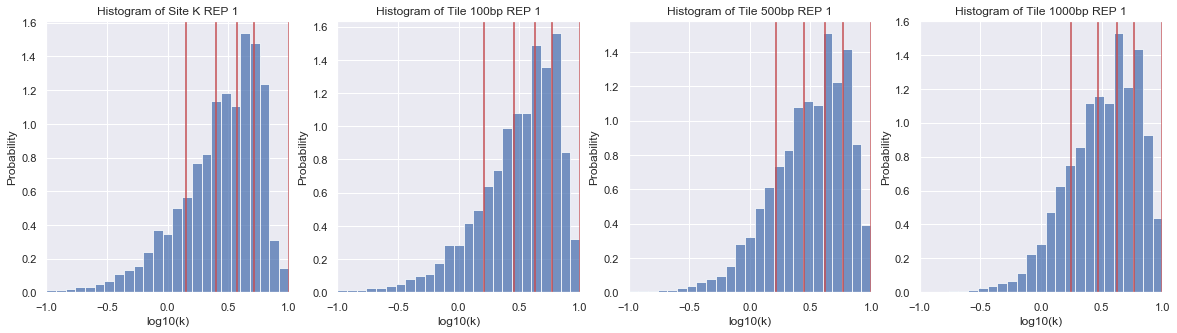

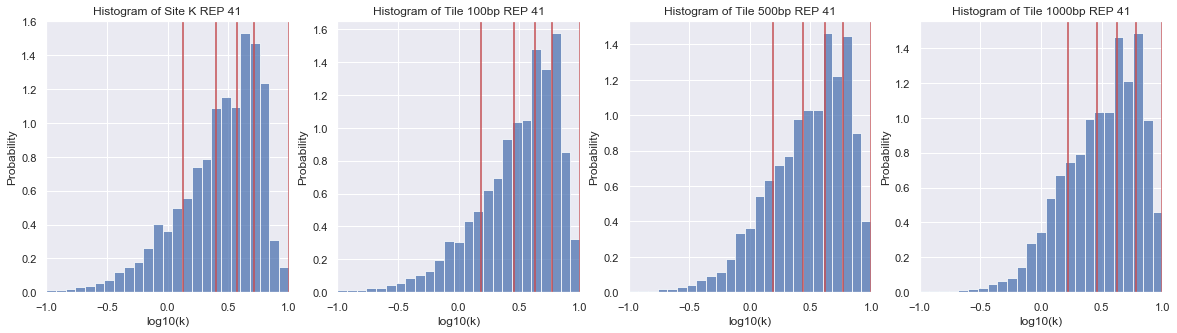

In [26]:
def plot_5_classes_of_K_by_histogram():
    for repli in REPLIS:
        repli_dir = os.path.join(ORIGIN_DATA_DIR, "Rep" + str(repli))
        classified_repli_dir = os.path.join(CLASSIFIED_DATA_DIR, "Rep" + str(repli))
        mkdirs([repli_dir, classified_repli_dir])
        k_arr = []
        percs = []
        for tile_window_sz in Tile_window_szs:
            file_name = 'tile_' + str(tile_window_sz)
            f_path = os.path.join(repli_dir, file_name + ".csv")
            df = pd.read_csv(f_path, sep=',', header=None).values

            ks = df[:, 2]
            ks[ks <= 0] = 0.001
            ks = np.log10(ks)
            df[:, 2] = ks

            percentiles = [-2.0]
            percentile_names = []
            for i in range(1, N_CLASSES + 1):
                percentile = i * 20
                percentile_names.append(str(percentile))
                percentiles.append(float(np.percentile(ks, percentile)))
            percs.append(percentiles[1:])
            #         class_datas = []
            #             for p_idx in range(0, N_CLASSES):
            #                 df_indexs = np.logical_and(ks > percentiles[p_idx], ks < percentiles[p_idx + 1])
            #                 class_datas.append(df[df_indexs, :])

            #             for c_i, class_data in enumerate(class_datas):
            #                 (row_len, col_len) = class_data.shape
            #                 bed_data = np.zeros((row_len, col_len + 1))
            #                 bed_data[:, [0, 1, 3]] = class_data
            #                 bed_data[:, 2] = class_data[:, 1] + 1
            #                 out_fp = os.path.join(classified_repli_dir, file_name + "_" + CLASS_LABELS[c_i] + '.bed')
            #                 np.savetxt(out_fp, bed_data[:, :], fmt="chr%d\t%d\t%d\t%.4f", delimiter='\n')
            #                 print("finish %s" % out_fp)
            k_arr.append(ks)

        fig, axs = plt.subplots(1, len(Tile_window_szs),
                                figsize=(len(Tile_window_szs) * EACH_SUB_FIG_SIZE, EACH_SUB_FIG_SIZE))
        for tile_idx, tile_window_sz in enumerate(Tile_window_szs):
            ax = axs[tile_idx]
            ax.hist(k_arr[tile_idx], 50, density=True, facecolor='b', alpha=0.75)
            for percentile in percs[tile_idx]:
                ax.axvline(x=percentile, color='r')
            ax.set_xlabel('log10(k)')
            ax.set_ylabel('Probability')
            ax.set_title('Histogram of ' + TILE_LABLES[tile_idx] + " REP " + str(repli))
            ax.set_xlim(-1, 1)
        plt.savefig("../FIGURES/FEATURE_ANALYSIS/Hist_" + str(repli) + ".png", dpi=200)

In [3]:
ChrmoHMM_DIR = os.path.join(DATA_SET_DIR, 'ChrmoHMM_INTERSECTED')

In [102]:
def barplot_of_ChrMM_for_each_k_categories():
    fig_dir = os.path.join(FIGURE_DIR, "ChromHMM")
    if not os.path.exists(fig_dir):
            os.makedirs(fig_dir)
    MCLASS_LABELS = ['empty', 'slowest k', 'slow k', 'middle k', 'fast k', 'fastest k']
    cm = plt.get_cmap('gist_rainbow')
    for repli in REPLIS:
        repli_dir = os.path.join(ChrmoHMM_DIR, "Rep" + str(repli))

        fig, axs = plt.subplots(1, len(Tile_window_szs),figsize=(len(Tile_window_szs) * EACH_SUB_FIG_SIZE, EACH_SUB_FIG_SIZE))

        for tid, tile_window_sz in enumerate(Tile_window_szs):
            if len(Tile_window_szs) != 1:
                ax = axs[tid]
            else:
                ax = axs
            width = 0.35
            ind = np.arange(len(CLASS_LABELS))
            chrHMMs = np.arange(NUMBER_OF_CHRMM_CLASS)
            class_data = np.zeros((len(chrHMMs), len(ind)))
            for cid, class_label in enumerate(CLASS_LABELS):
                file_name = 'tile_' + str(tile_window_sz) + "_" + class_label
                f_path = os.path.join(repli_dir, file_name + ".csv")
                df = pd.read_csv(f_path, sep=',', header=None).values
                classes = df[:, 3]
                unique, counts = np.unique(classes, return_counts=True)
                unique=unique.astype(int)
                normed_counts = counts/float(counts.sum())
                unique_dc = dict(zip(unique, normed_counts))
                for cls in chrHMMs:
                    class_data[cls][cid] = unique_dc[cls+1]
            pls = []
            for cls in chrHMMs:
                if cls == 0:
                    pl = ax.bar(ind, tuple(list(class_data[cls, :])), width)
                else:
                    sum_prev= list(np.sum(class_data[0 : cls, :], axis = 0))
                    pl = ax.bar(ind, tuple(list(class_data[cls, :])), width, bottom=tuple(sum_prev))
                for item in pl:
                    item.set_color(cm(1. * cls / NUMBER_OF_CHRMM_CLASS))
                pls.append(pl)
            ax.set_xlabel('ChromHMM Class')
            ax.set_ylabel('Percentage')
            ax.set_xticklabels(MCLASS_LABELS)
            ax.set_yticks(np.arange(0.2, 1.1, 0.2))
            ax.set_title(TILE_LABLES[tid] + " REP " + str(repli))
            if tid == 0:
                box = ax.get_position()
                ax.set_position([box.x0, box.y0, box.width * 0.7, box.height])
                ax.legend(tuple(pls), tuple(ChrmoHMM_LABELS), loc='center left', bbox_to_anchor=(1, 0.5))
        plt.savefig(os.path.join(fig_dir, "ChromHMM_Rep"+str(repli) +"_PERCENTAGE_OF_K.png"), dpi=200)

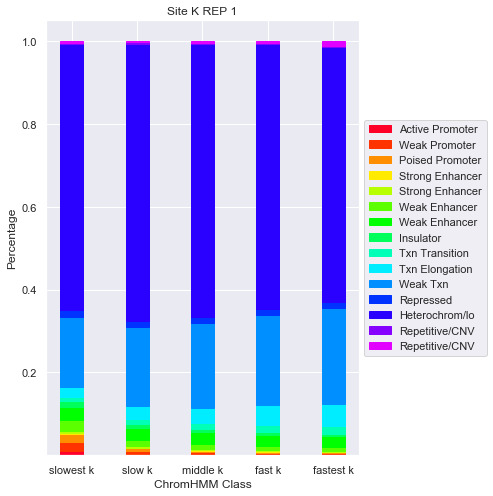

In [39]:
barplot_of_ChrMM_for_each_k_categories()

In [128]:
def barplot_of_ChrMM_for_each_k_categories_separately():
    fig_dir = os.path.join(FIGURE_DIR, "ChromHMM")
    if not os.path.exists(fig_dir):
            os.makedirs(fig_dir)
    MCLASS_LABELS = ['empty', 'slowest k', 'slow k', 'middle k', 'fast k', 'fastest k']
    cm = plt.get_cmap('gist_rainbow')
    repli = 55
    repli_dir = os.path.join(ChrmoHMM_DIR, "Rep" + str(repli))
    N_ROW = 3
    N_COL = 5
    fig, axs = plt.subplots(N_ROW, N_COL,figsize=(N_COL * EACH_SUB_FIG_SIZE, N_ROW * EACH_SUB_FIG_SIZE))

    ind = np.arange(len(CLASS_LABELS))
    chrHMMs = np.arange(NUMBER_OF_CHRMM_CLASS)
    class_data = np.zeros((len(chrHMMs), len(ind)))
    class_data_non_normed = np.zeros((len(chrHMMs), len(ind)))
    for cid, class_label in enumerate(CLASS_LABELS):
        file_name = "tile_2_" + class_label
        f_path = os.path.join(repli_dir, file_name + ".csv")
        df = pd.read_csv(f_path, sep=',', header=None).values
        classes = df[:, 3]
        unique, counts = np.unique(classes, return_counts=True)
        unique = unique.astype(int)
        normed_counts = counts / float(counts.sum())
        unique_dc = dict(zip(unique, normed_counts))
        unique_dc_non_normed = dict(zip(unique, counts))
        for cls in chrHMMs:
            class_data[cls][cid] = unique_dc[cls + 1]
            class_data_non_normed[cls][cid] = unique_dc_non_normed[cls + 1]

    for cls in chrHMMs:
        row = int(cls / N_COL)
        col = int(cls % N_COL)
        ax = axs[row][col]
        y_max = np.max(class_data[cls, :]) + 0.08
        pl = ax.bar(ind, tuple(list(class_data[cls, :])), 0.35)
        for item in pl:
            item.set_color(cm(1. * cls / NUMBER_OF_CHRMM_CLASS))
        for cid, class_label in enumerate(CLASS_LABELS):
            ax.text(ind[cid] - 0.2, class_data[cls, cid] + 0.002, str(round(class_data[cls, cid] * 100.0, 2)) + "%", fontsize= 14, weight="bold")
        if col == 0:
            ax.set_ylabel('Percentage')
        ax.set_xticklabels(MCLASS_LABELS, fontsize=18)
        ax.set_ylim(0, y_max)
        ax.set_title(ChrmoHMM_LABELS[cls], fontsize=22)
    plt.savefig(os.path.join(fig_dir, "ChromHMM_Rep" + str(repli) + "_SEP_PERCENTAGE_OF_K.png"), dpi=200)

    fig, axs = plt.subplots(N_ROW, N_COL,figsize=(N_COL * EACH_SUB_FIG_SIZE, N_ROW * EACH_SUB_FIG_SIZE))
    for cls in chrHMMs:
        row = int(cls / N_COL)
        col = int(cls % N_COL)
        ax = axs[row][col]
        class_data_non_normed[cls, :] = class_data_non_normed[cls, :] / np.sum(class_data_non_normed[cls, :])
        y_max = np.max(class_data_non_normed[cls, :]) + 0.08
        pl = ax.bar(ind, tuple(list(class_data_non_normed[cls, :])), 0.35)
        for item in pl:
            item.set_color(cm(1. * cls / NUMBER_OF_CHRMM_CLASS))
        for cid, class_label in enumerate(CLASS_LABELS):
            ax.text(ind[cid] - 0.2, class_data_non_normed[cls, cid] + 0.002, str(round(class_data_non_normed[cls, cid] * 100.0, 2)) + "%", fontsize= 14, weight="bold")
        if col == 0:
            ax.set_ylabel('Percentage')
        ax.set_xticklabels(MCLASS_LABELS, fontsize=18)
        y_max = np.max(class_data_non_normed[cls, :]) + 0.08
        ax.set_ylim(0, y_max)
        ax.set_title(ChrmoHMM_LABELS[cls], fontsize=22)
    plt.savefig(os.path.join(fig_dir, "ChromHMM_Rep" + str(repli) + "_SEP_PERCENTAGE_OF_ChroMM.png"), dpi=200)

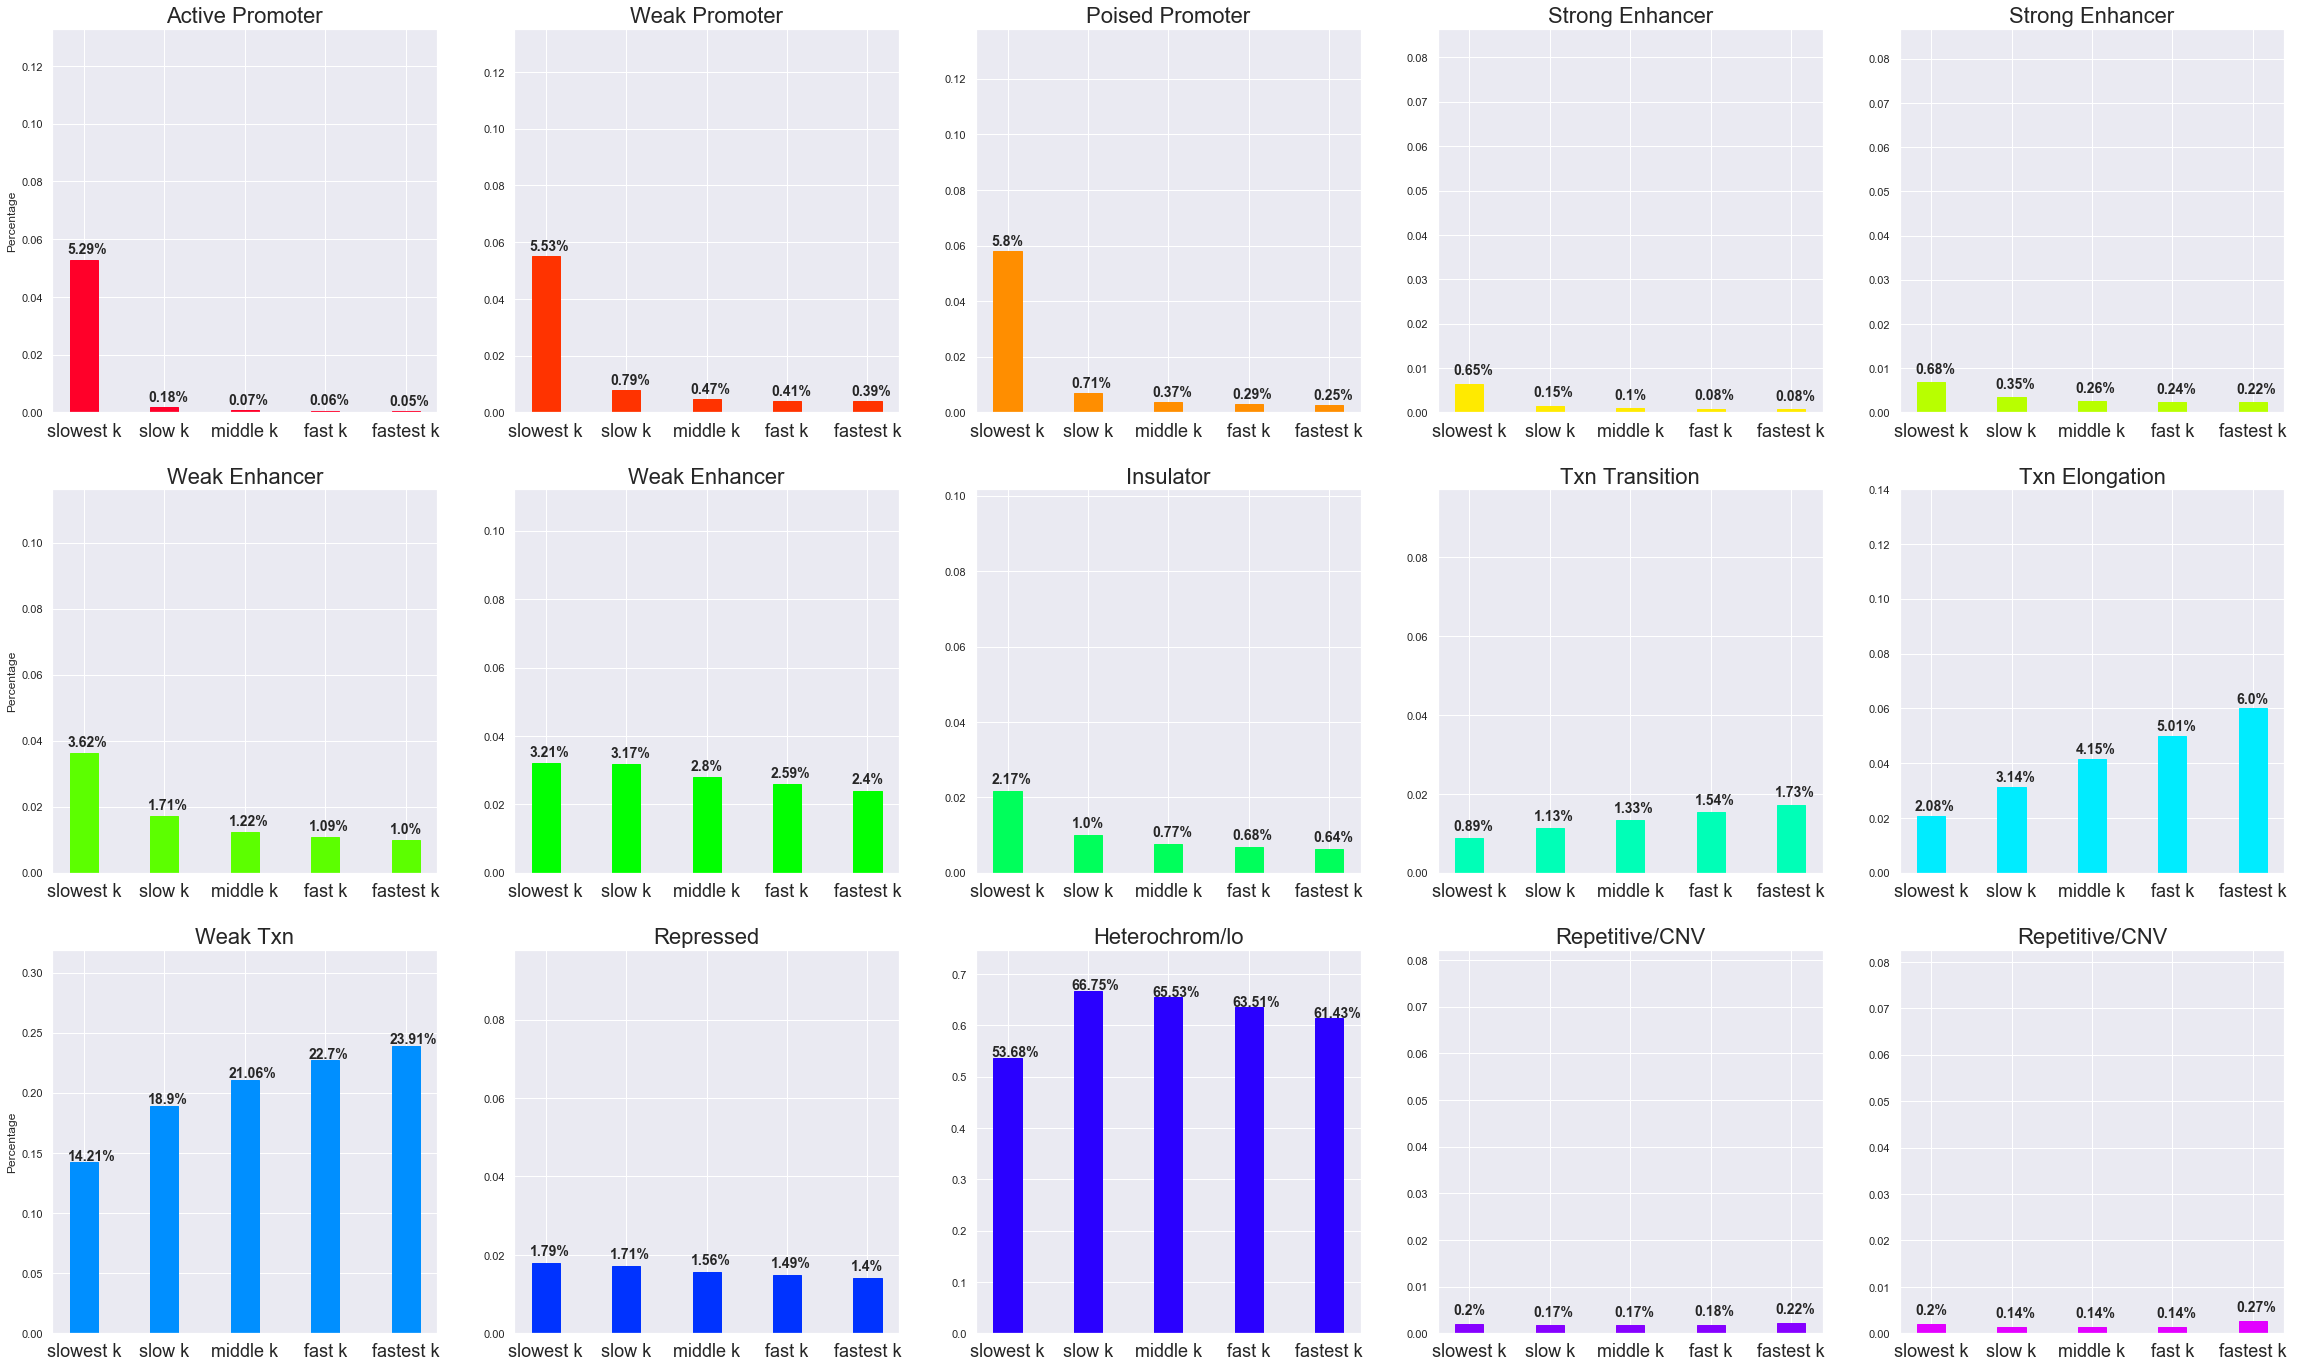

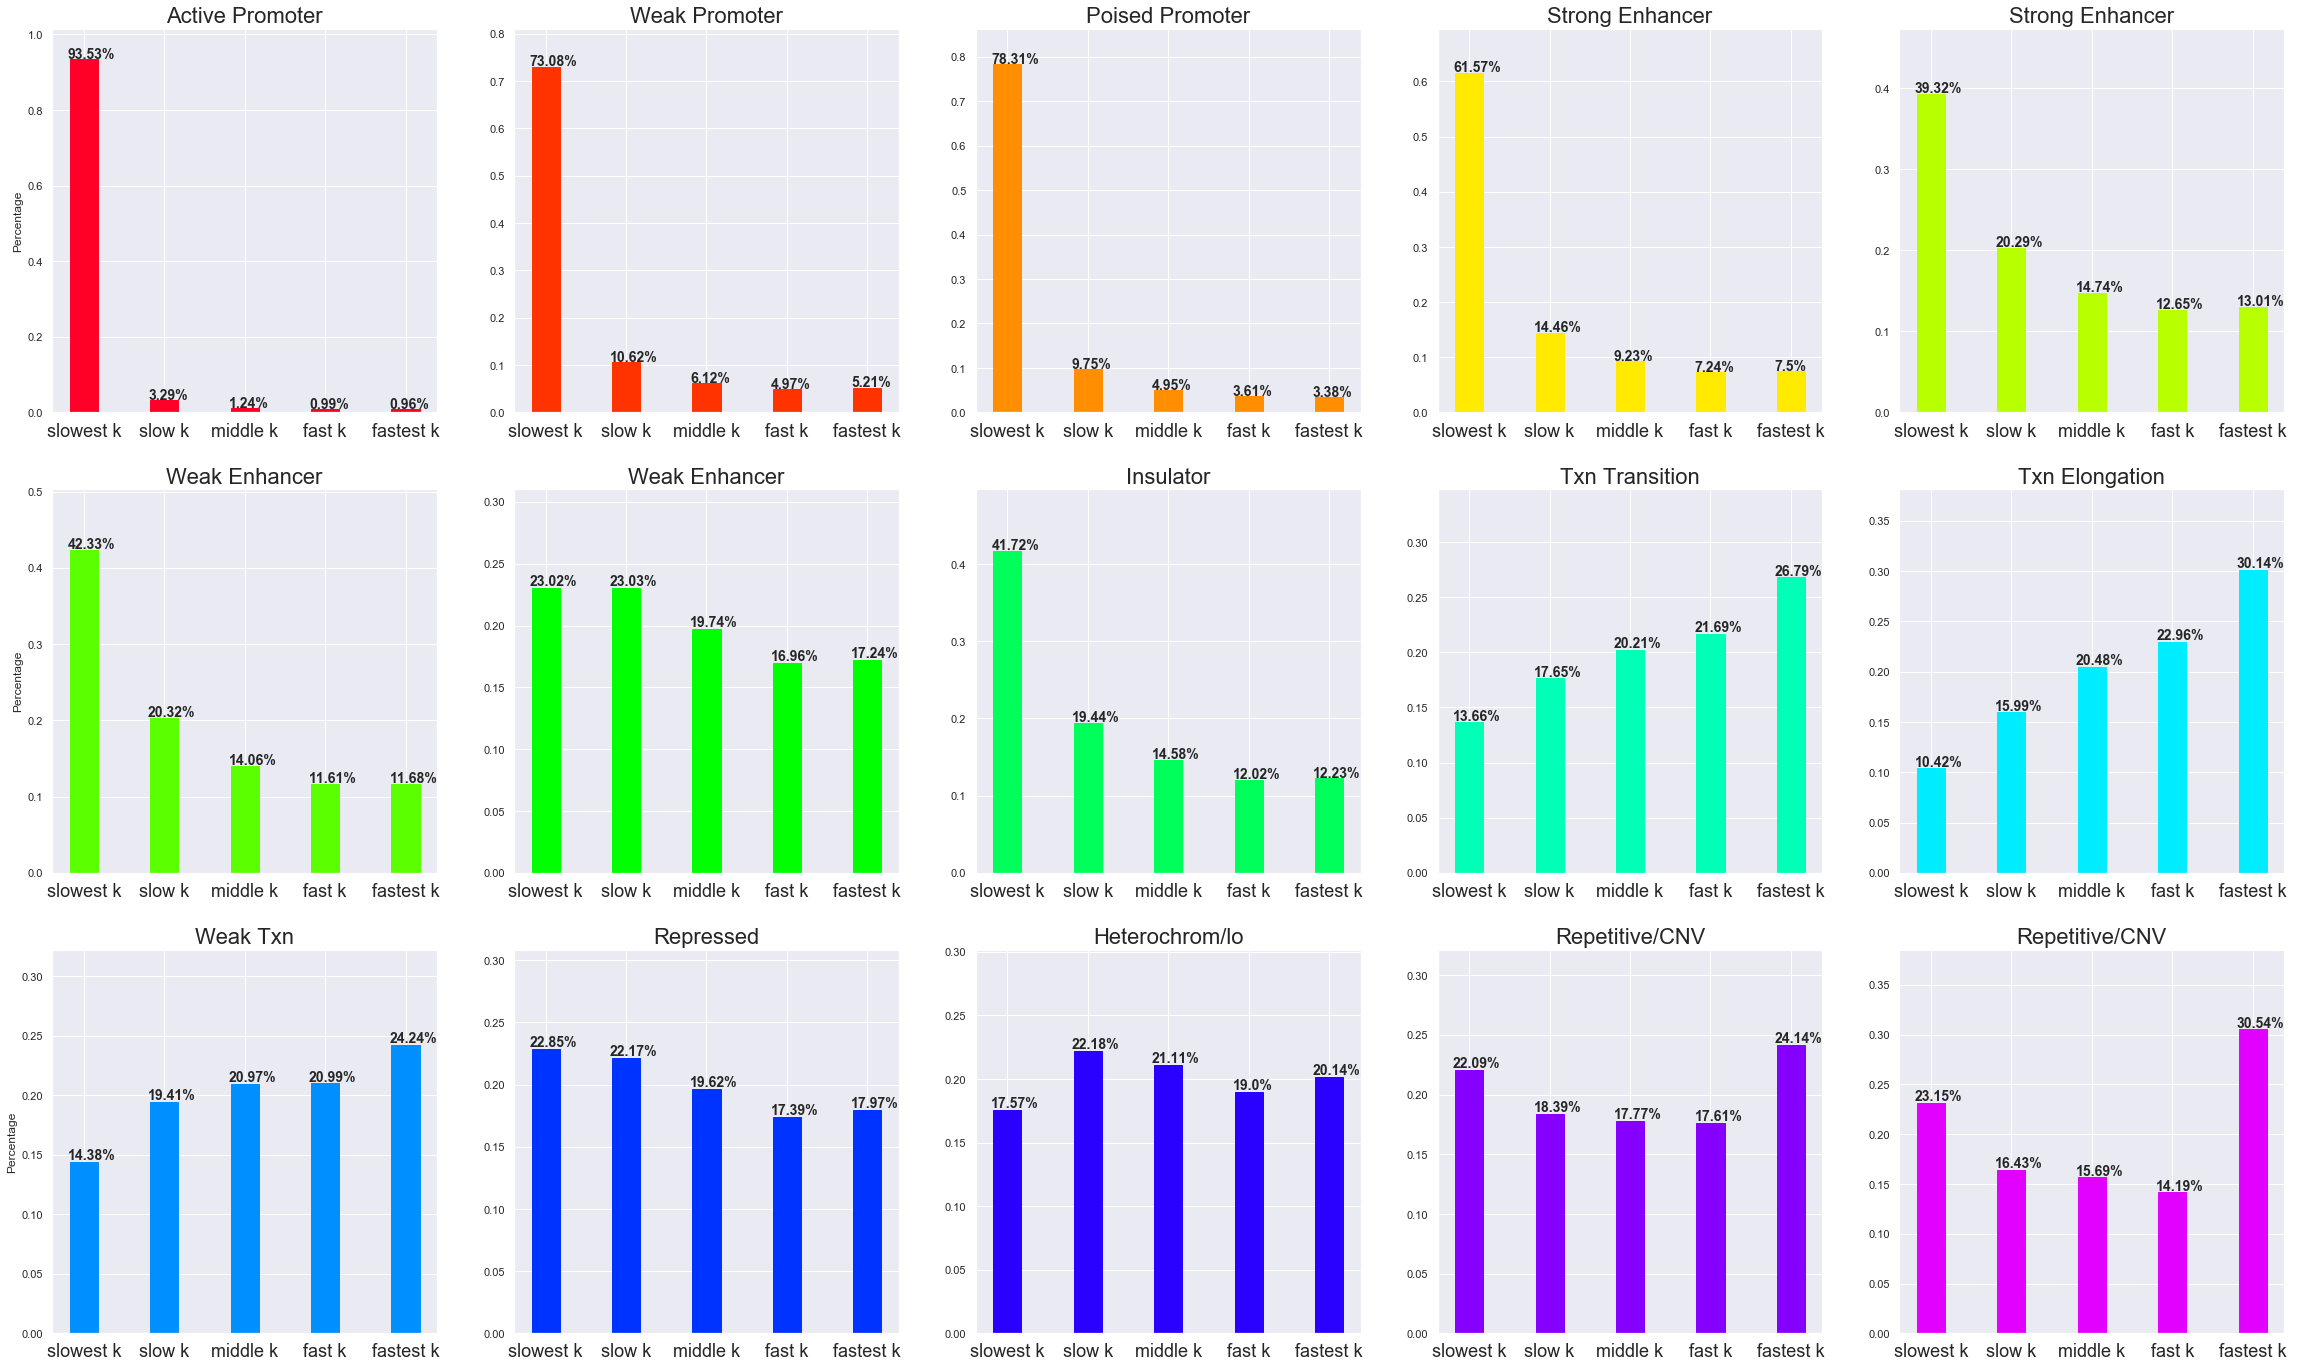

In [129]:
barplot_of_ChrMM_for_each_k_categories_separately()

In [72]:
def plot_hist_of_distances_between_ks():
    MAX_DIST = 2000
    repli = 55
    data_fp = os.path.join(ORIGIN_DATA_DIR, 'Rep' + str(repli), 'tile_2.csv')
    df = pd.read_csv(data_fp, sep=',', header=None).values
    ks = df[:, 2]
    ks[ks <= 0] = 0.001
    df[:, 2] = np.log10(ks)
    dists = np.array([])
    K_pairs = np.array([])
    for chr_i in CHROMOSOMES:
        chr_indexs = df[:, 0].astype(int) == chr_i
        df_chr = df[chr_indexs, 1]
        ds = df_chr[1:] - df_chr[0:-1]
        dists = np.concatenate((dists, ds), axis=0) if dists.size != 0 else ds

        k_arr = df[chr_indexs, 2].reshape(-1,1)
        kps = np.concatenate((k_arr[0:-1], k_arr[1:]), axis=1)
        K_pairs = np.concatenate((K_pairs, kps), axis=0) if K_pairs.size != 0 else kps

    dists = dists[dists < MAX_DIST]
    corr_coef = np.corrcoef(K_pairs[:, 0], K_pairs[:, 1])[0][1]

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    ax = axs[0]
    ax.hist(dists, 20, density=True, facecolor='b', alpha=0.75)
    ax.set_xlabel('Distance(bp)')
    ax.set_ylabel('Probability')
    ax.set_xlim(0, MAX_DIST)
    ax.set_title("Histogram of the distance between K")

    ax2 = axs[1]
    ax2.hist2d(K_pairs[:, 0], K_pairs[:, 1], bins=(30, 30))
    ax2.set_xlabel('log10(K)')
    ax2.set_ylabel('log10(K) neighbor')
    ax2.set_xlim(-1, 1)
    ax2.set_ylim(-1, 1)
    ax2.set_title("Hist2d of log10(K) and Neighbor log10(K) with Corr " + str(round(float(corr_coef), 2)))

    plt.savefig("../FIGURES/FEATURE_ANALYSIS/Hist_of_Distance.png", dpi=200)

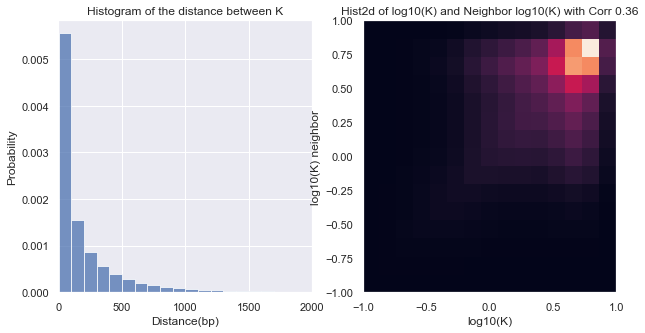

In [73]:
plot_hist_of_distances_between_ks()

In [20]:
def hist_for_logk_distribution(percentile):
    fig, axs = plt.subplots(1, 1, figsize=(4, 3))
    repli = 55
    for tid, tile_window_sz in enumerate(Tile_window_szs):
        data_fp = os.path.join(ORIGIN_DATA_DIR, 'Rep' + str(repli), 'tile_' + str(tile_window_sz) + '.csv')
        df = pd.read_csv(data_fp, sep=',', header=None).values
        ks = df[:, 2]
        ks[ks <= 0] = 0.001
        ks = np.log10(ks)
        ax = axs
        ax.hist(ks, 40, density=True, facecolor='b', alpha=0.75)
        ax.axvline(x=np.percentile(ks, percentile), color='r')
        ax.text(np.percentile(ks, percentile), 1, str(percentile) + " percentile", color="r")
        ax.set_ylabel('Probability')
        ax.set_xlim(-0.75, 1)
        ax.set_title("log10(k) in " + TILE_LABLES[tid])
        if tid!=len(Tile_window_szs) - 1:
            ax.set_xticks([])
        else:
            ax.set_xlabel('log10(k)')
    plt.savefig("../FIGURES/FEATURE_ANALYSIS/VIOLIN_PLOT.png", dpi=200)

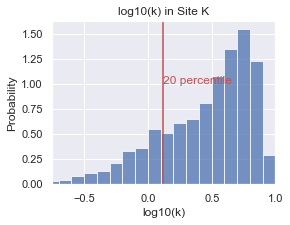

In [21]:
hist_for_logk_distribution(20)

In [67]:
def plot_for_logk_and_methy():
    data_fp = os.path.join(K_METHY_DIR, "K_and_methy_intersected.csv")

    plt.figure(figsize=(4, 3), dpi=120)
    df = pd.read_csv(data_fp, sep=',', header=None).values
    ks = df[:, 2]
    methys = df[:, 3]
    ks[ks <= 0] = 0.001
    ks = np.log10(ks)
    corr_coef = np.corrcoef(ks,methys)[0][1]
    h = plt.hist2d(methys, ks, bins=(30, 30))
    plt.colorbar(h[3])
    plt.xlabel('Methylation level')
    plt.ylabel('log10(K)')
    plt.ylim(-1, 1)
    plt.xlim(0, 1)
    plt.title("Hist2d of Methy vs log10(K) with Correlation " + str(round(float(corr_coef), 2)))
    plt.savefig("../FIGURES/FEATURE_ANALYSIS/METHY_VS_K.png", dpi=200)

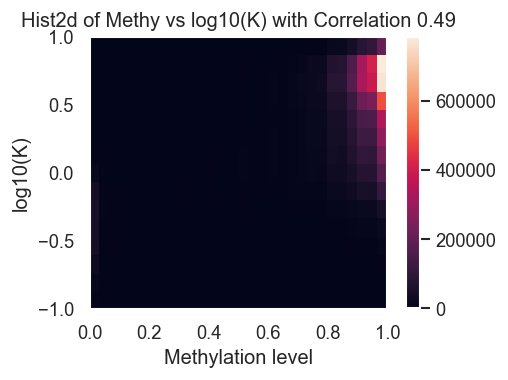

In [68]:
plot_for_logk_and_methy()

In [119]:
def plot_gc_content_percentage_in_each_K_class(wrting_data=False):
    CG_CONTENT_LABELS = ["LCG < 30%", "ICG 30%-60%", "HCG > 60%"]
    MCLASS_LABELS = ['empty', 'slowest k', 'slow k', 'middle k', 'fast k', 'fastest k']
    REPLIS = [55]#1, 41
    wrting_data=False
    cm = plt.get_cmap('gist_rainbow')

    indir = os.path.join(DATA_SET_DIR, "CG_Analysis")
    outdir = os.path.join(indir, "Classified_data")
    if not os.path.exists(outdir):
        os.makedirs(outdir)

    radius = [25, 50, 75]
    k_col_index = 3
    cg_col_index = 5
    lcg = 0.35 #threshold between low_cg_percent and intermediate
    hcg = 0.6 # threshold between intermediate and high
    fig_dir = os.path.join(FIGURE_DIR, "CG_CONTENT")
    if not os.path.exists(fig_dir):
            os.makedirs(fig_dir)
    r = 25
    input_fp = os.path.join(indir, "55_flank_" + str(r) +"_GC.csv")
    output_filename = os.path.join(outdir, "55_flank_" + str(r) +"_GC")

    percs = []
    df = pd.read_csv(input_fp, sep=',', header=None).values

    ks = df[:, k_col_index]
    ks[ks <= 0] = 0.001
    ks = np.log10(ks)
    df[:, k_col_index] = ks

    percentiles = [-2.0]
    percentile_names = []
    for i in range(1, N_CLASSES + 1):
        percentile = i * 20
        percentile_names.append(str(percentile))
        percentiles.append(float(np.percentile(ks, percentile)))
    percs.append(percentiles[1:])

    class_datas = []
    for p_idx in range(0, N_CLASSES):
        df_indexs = np.logical_and(ks > percentiles[p_idx], ks < percentiles[p_idx + 1])
        origin_data = df[df_indexs, :]
        cg_category = np.ones((origin_data.shape[0], 1)).reshape(-1,1) * 2.0
        lcg_indexs = origin_data[:, cg_col_index] < lcg
        hcg_indexs = origin_data[:, cg_col_index] > hcg
        cg_category[lcg_indexs] = 1
        cg_category[hcg_indexs] = 3
        class_datas.append(np.concatenate((origin_data, cg_category), axis=1))
    # wring data
    if wrting_data:
        for c_i, class_data in enumerate(class_datas):
            out_fp = os.path.join(output_filename + "_" + CLASS_LABELS[c_i] + '.csv')
            np.savetxt(out_fp, class_data[:, :],fmt = "%d,%d,%d,%.4f,%.4f,%.4f,%d", delimiter = '\n')
            print("finish %s" % out_fp)
    fig = plt.figure(figsize=(10, 6), dpi=120)

    ind = np.arange(len(CLASS_LABELS))
    CGS = np.arange(len(CG_CONTENT_LABELS))

    class_data = np.zeros((len(CGS), len(ind)))
    class_data_non_normed = np.zeros((len(CGS), len(ind)))
    for cid, class_label in enumerate(CLASS_LABELS):
        origin_data = class_datas[cid]
        cg_classes = origin_data[:, -1].astype(int)

        unique, counts = np.unique(cg_classes, return_counts=True)
        unique = unique.astype(int)
        normed_counts = counts / float(counts.sum())
        unique_dc = dict(zip(unique, normed_counts))
        unique_dc_non_normed = dict(zip(unique, counts))
        for cls in CGS:
            class_data[cls][cid] = unique_dc[cls + 1]
            class_data_non_normed[cls][cid] = unique_dc_non_normed[cls + 1]
    pls = []
    for cls in CGS:
        if cls == 0:
            pl = plt.bar(ind, tuple(list(class_data[cls, :])), 0.35)
        else:
            sum_prev = list(np.sum(class_data[0: cls, :], axis=0))
            pl = plt.bar(ind, tuple(list(class_data[cls, :])), 0.35, bottom=tuple(sum_prev))
        for item in pl:
            item.set_color(cm(1. * cls / len(CG_CONTENT_LABELS)))
        pls.append(pl)
    plt.xlabel('K Class')
    plt.ylabel('Percentage')
    plt.xticks(ind, CLASS_LABELS)
    plt.yticks(np.arange(0.2, 1.1, 0.2))
    plt.legend(tuple(pls), tuple(CG_CONTENT_LABELS))
    plt.title("Percentage of CG Content in Each K class with local radius" + str(r))
    plt.savefig(os.path.join(fig_dir, "CG_CONTENT_PERCENTAGE_OF_K_R_" + str(r) + ".png"), dpi=200)

    N_COL = len(CGS)
    fig, axs = plt.subplots(1, N_COL,figsize=(N_COL * EACH_SUB_FIG_SIZE, 1 * EACH_SUB_FIG_SIZE))
    for cls in CGS:
        ax = axs[cls]
        y_max = np.max(class_data[cls, :]) + 0.08
        pl = ax.bar(ind, tuple(list(class_data[cls, :])), 0.35)
        for item in pl:
            item.set_color(cm(1. * cls / N_COL))
        for cid, class_label in enumerate(CLASS_LABELS):
            ax.text(ind[cid] - 0.2, class_data[cls, cid] + 0.002, str(round(class_data[cls, cid] * 100.0, 2)) + "%", fontsize= 14, weight="bold")
        if cls == 0:
            ax.set_ylabel("Percentage" +", CG local radius " + str(r),  fontsize=22)
        ax.set_xticklabels(MCLASS_LABELS, fontsize=18)
        ax.set_ylim(0, y_max)
        ax.set_title(CG_CONTENT_LABELS[cls], fontsize=22)
    plt.savefig(os.path.join(fig_dir, "CG_CONTENT_PERCENTAGE_OF_K_SEP_R_" + str(r) + ".png"), dpi=200)
    
    fig, axs = plt.subplots(1, N_COL,figsize=(N_COL * EACH_SUB_FIG_SIZE, 1 * EACH_SUB_FIG_SIZE))
    for cls in CGS:
        ax = axs[cls]
        class_data_non_normed[cls, :] = class_data_non_normed[cls, :] / np.sum(class_data_non_normed[cls, :])
        y_max = np.max(class_data_non_normed[cls, :]) + 0.08
        pl = ax.bar(ind, tuple(list(class_data_non_normed[cls, :])), 0.35)
        for item in pl:
            item.set_color(cm(1. * cls / N_COL))
        for cid, class_label in enumerate(CLASS_LABELS):
            ax.text(ind[cid] - 0.2, class_data_non_normed[cls, cid] + 0.002, str(round(class_data_non_normed[cls, cid] * 100.0, 2)) + "%", fontsize= 14, weight="bold")
        if cls == 0:
            ax.set_ylabel("Percentage" +", CG local radius " + str(r),  fontsize=22)
        ax.set_xticklabels(MCLASS_LABELS, fontsize=18)
        ax.set_ylim(0, y_max)
        ax.set_title(CG_CONTENT_LABELS[cls], fontsize=22)
    plt.savefig(os.path.join(fig_dir, "CG_CONTENT_PERCENTAGE_OF_CG_SEP_R_" + str(r) + ".png"), dpi=200)

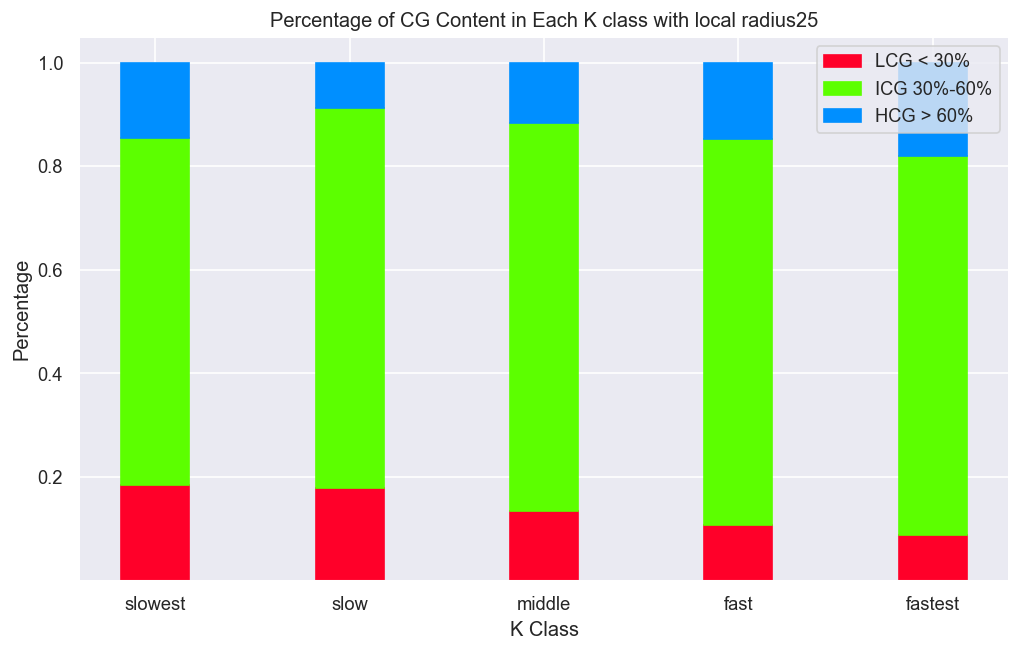

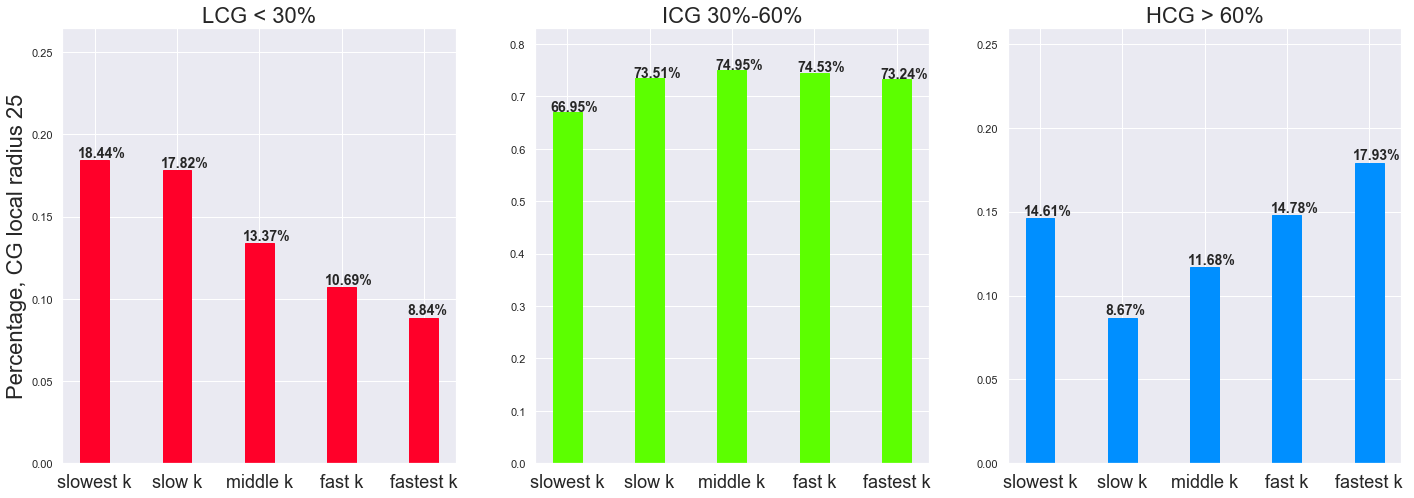

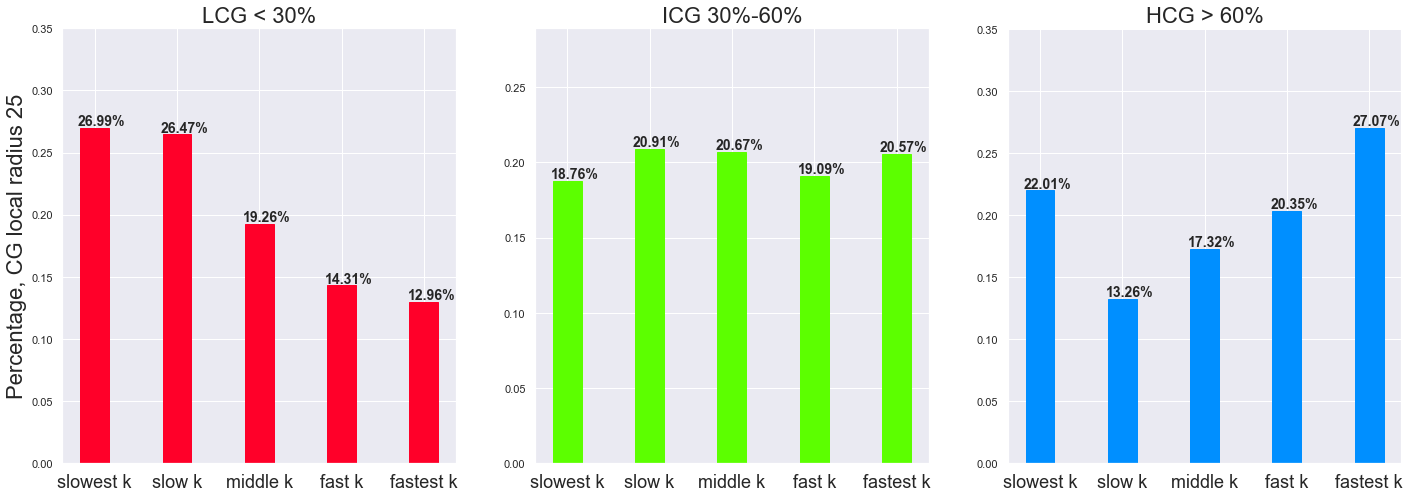

In [120]:
plot_gc_content_percentage_in_each_K_class()

In [12]:
def plot_K_in_methy_context():
    indir = os.path.join(DATA_SET_DIR, "K_Methylation_Analysis")
    METHY_LABELS = ["Unmethy: < 0.3", "IM: 0.3-0.7", "Methylated: > 0.7"]
    cm = plt.get_cmap('gist_rainbow')

    k_col_index = 2
    methy_col_index = 3

    unmethy_threshold = 0.3  # threshold between unmethylated and intermediate methylated
    methy_threshold = 0.7  # threshold between intermediate methylated and methylated

    fig_dir = os.path.join(FIGURE_DIR, "K_METHYLATION")
    if not os.path.exists(fig_dir):
        os.makedirs(fig_dir)

    input_fp = os.path.join(indir, "K_and_methy_intersected.csv")

    # Classify K by percentile and label K by methylation level
    percs = []
    df = pd.read_csv(input_fp, sep=',', header=None).values

    ks = df[:, k_col_index]

    ks[ks <= 0] = 0.001
    ks = np.log10(ks)
    df[:, k_col_index] = ks

    percentiles = [-2.0]
    percentile_names = []
    for i in range(1, N_CLASSES + 1):
        percentile = i * 20
        percentile_names.append(str(percentile))
        percentiles.append(float(np.percentile(ks, percentile)))
    percs.append(percentiles[1:])

    class_datas = []
    for p_idx in range(0, N_CLASSES):
        df_indexs = np.logical_and(ks > percentiles[p_idx], ks < percentiles[p_idx + 1])
        origin_data = df[df_indexs, :]

        methy_category = np.ones((origin_data.shape[0], 1)).reshape(-1, 1) * 2.0

        unmethy_indexs = origin_data[:, methy_col_index] < unmethy_threshold
        methy_category[unmethy_indexs] = 1

        methy_indexs = origin_data[:, methy_col_index] > methy_threshold
        methy_category[methy_indexs] = 3

        class_datas.append(np.concatenate((origin_data, methy_category), axis=1))

    fig = plt.figure(figsize=(10, 6), dpi=120)
    ind = np.arange(len(CLASS_LABELS))
    CGS = np.arange(len(METHY_LABELS))

    class_data = np.zeros((len(CGS), len(ind)))
    class_data_non_normed = np.zeros((len(CGS), len(ind)))
    for cid, class_label in enumerate(CLASS_LABELS):
        origin_data = class_datas[cid]
        cg_classes = origin_data[:, -1].astype(int)

        unique, counts = np.unique(cg_classes, return_counts=True)
        unique = unique.astype(int)
        normed_counts = counts / float(counts.sum())
        unique_dc = dict(zip(unique, normed_counts))
        unique_dc_non_normed = dict(zip(unique, counts))
        for cls in CGS:
            class_data[cls][cid] = unique_dc[cls + 1]
            class_data_non_normed[cls][cid] = unique_dc_non_normed[cls + 1]
    pls = []
    for cls in CGS:
        if cls == 0:
            pl = plt.bar(ind, tuple(list(class_data[cls, :])), 0.35)
        else:
            sum_prev = list(np.sum(class_data[0: cls, :], axis=0))
            pl = plt.bar(ind, tuple(list(class_data[cls, :])), 0.35, bottom=tuple(sum_prev))
        for item in pl:
            item.set_color(cm(1. * cls / len(METHY_LABELS)))
        pls.append(pl)
    plt.xlabel('K Class')
    plt.ylabel('Percentage')
    plt.xticks(ind, CLASS_LABELS)
    plt.yticks(np.arange(0.2, 1.1, 0.2))
    plt.legend(tuple(pls), tuple(METHY_LABELS))
    plt.title("Percentage of Methylation in Each K class")
    plt.savefig(os.path.join(fig_dir, "METHY_PERCENTAGE_OF_K.png"), dpi=200)

    N_COL = len(CGS)
    fig, axs = plt.subplots(1, N_COL, figsize=(N_COL * EACH_SUB_FIG_SIZE, 1 * EACH_SUB_FIG_SIZE))
    for cls in CGS:
        ax = axs[cls]
        y_max = np.max(class_data[cls, :]) + 0.08
        pl = ax.bar(ind, tuple(list(class_data[cls, :])), 0.35)
        for item in pl:
            item.set_color(cm(1. * cls / N_COL))
        for cid, class_label in enumerate(CLASS_LABELS):
            ax.text(ind[cid] - 0.2, class_data[cls, cid] + 0.002, str(round(class_data[cls, cid] * 100.0, 2)) + "%",
                    fontsize=14, weight="bold")
        if cls == 0:
            ax.set_ylabel("Percentage", fontsize=22)
        ax.set_xticks(ind)
        ax.set_xticklabels(CLASS_LABELS, fontsize=14)
        ax.set_ylim(0, y_max)
        ax.set_title(METHY_LABELS[cls], fontsize=22)
    plt.savefig(os.path.join(fig_dir, "METHY_PERCENTAGE_OF_K_SEP.png"), dpi=200)

    fig, axs = plt.subplots(1, N_COL, figsize=(N_COL * EACH_SUB_FIG_SIZE, 1 * EACH_SUB_FIG_SIZE))
    for cls in CGS:
        ax = axs[cls]
        class_data_non_normed[cls, :] = class_data_non_normed[cls, :] / np.sum(class_data_non_normed[cls, :])
        y_max = np.max(class_data_non_normed[cls, :]) + 0.08
        pl = ax.bar(ind, tuple(list(class_data_non_normed[cls, :])), 0.35)
        for item in pl:
            item.set_color(cm(1. * cls / N_COL))
        for cid, class_label in enumerate(CLASS_LABELS):
            ax.text(ind[cid] - 0.2, class_data_non_normed[cls, cid] + 0.002,
                    str(round(class_data_non_normed[cls, cid] * 100.0, 2)) + "%",
                    fontsize=14, weight="bold")
        if cls == 0:
            ax.set_ylabel("Percentage", fontsize=22)
        ax.set_xticks(ind)
        ax.set_xticklabels(CLASS_LABELS, fontsize=14)
        ax.set_ylim(0, y_max)
        ax.set_title(METHY_LABELS[cls], fontsize=22)
    plt.savefig(os.path.join(fig_dir, "METHY_PERCENTAGE_OF_METHY_SEP.png"), dpi=200)

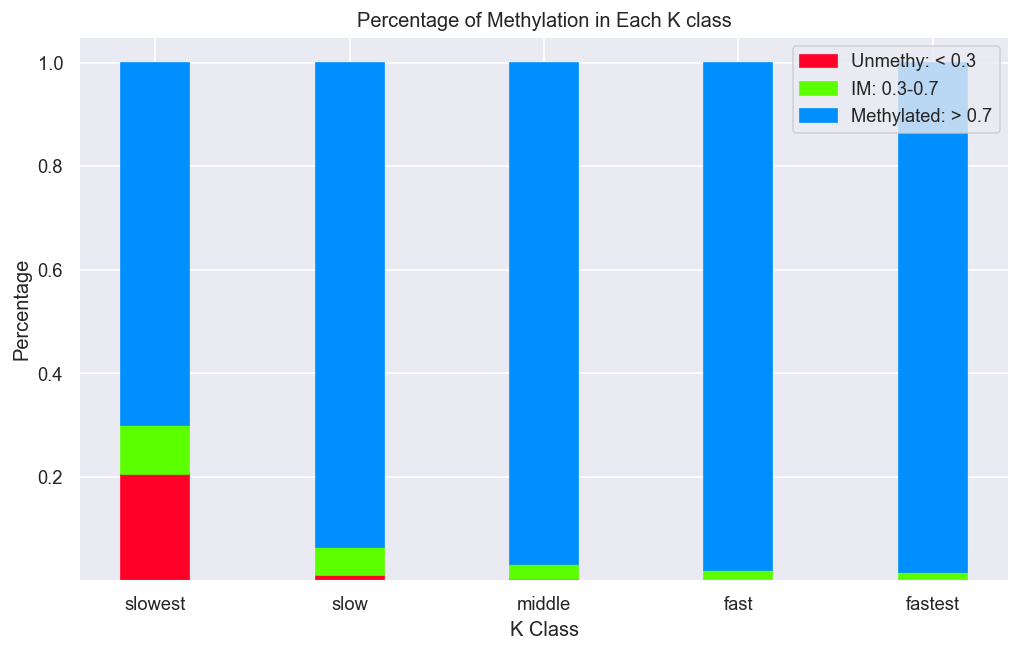

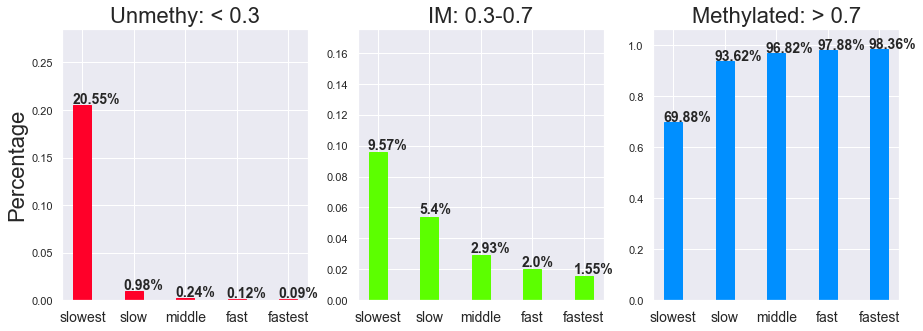

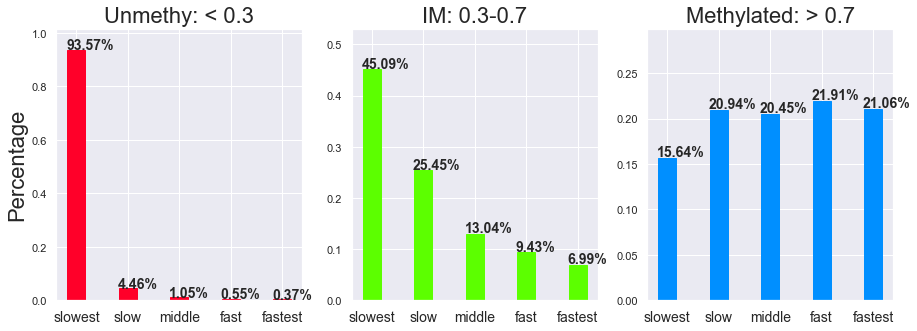

In [13]:
plot_K_in_methy_context()

In [7]:
def plot_K_in_promoter_or_CGI_context():
    PRO_CGI_LABELS = ["Promoter CGI", "Promoter Non-CGI", "Non-Promter CGI", "Non-Promter Non-CGI"]
    MCLASS_LABELS = ['empty', 'slowest k', 'slow k', 'middle k', 'fast k', 'fastest k']
    cm = plt.get_cmap('gist_rainbow')

    indir = os.path.join(DATA_SET_DIR, "CG_Analysis")

    k_col_index = 3
    promoter_col_index = 6
    cgi_col_index = 7
    ChrHMM_col_index = 8

    fig_dir = os.path.join(FIGURE_DIR, "CG_CONTENT")
    if not os.path.exists(fig_dir):
        os.makedirs(fig_dir)
    r = 25
    input_fp = os.path.join(indir, "55_flank_" + str(r) + "_Promoter_CGI_ChrHMM_annotated.csv")

    percs = []
    df = pd.read_csv(input_fp, sep=',', header=None).values

    ks = df[:, k_col_index]
    ks[ks <= 0] = 0.001
    ks = np.log10(ks)
    df[:, k_col_index] = ks

    percentiles = [-2.0]
    percentile_names = []
    for i in range(1, N_CLASSES + 1):
        percentile = i * 20
        percentile_names.append(str(percentile))
        percentiles.append(float(np.percentile(ks, percentile)))
    percs.append(percentiles[1:])

    non_promoter_cgi_k_slowest = None
    non_promoter_cgi_k_fastest = None

    class_datas = []
    for p_idx in range(0, N_CLASSES):
        df_indexs = np.logical_and(ks > percentiles[p_idx], ks < percentiles[p_idx + 1])
        origin_data = df[df_indexs, :]

        pro_cgi_category = np.ones((origin_data.shape[0], 1)).reshape(-1, 1)

        prom_cgi = np.logical_and(origin_data[:, promoter_col_index].astype(int) == 1,
                                  origin_data[:, cgi_col_index].astype(int) == 1)
        prom_non_cgi = np.logical_and(origin_data[:, promoter_col_index].astype(int) == 1,
                                      origin_data[:, cgi_col_index].astype(int) == 0)
        non_prom_cgi = np.logical_and(origin_data[:, promoter_col_index].astype(int) == 0,
                                      origin_data[:, cgi_col_index].astype(int) == 1)
        non_prom_non_cgi = np.logical_and(origin_data[:, promoter_col_index].astype(int) == 0,
                                          origin_data[:, cgi_col_index].astype(int) == 0)

        pro_cgi_category[prom_cgi] = 1
        pro_cgi_category[prom_non_cgi] = 2
        pro_cgi_category[non_prom_cgi] = 3
        pro_cgi_category[non_prom_non_cgi] = 4

        if p_idx == 0:  # slowest K
            non_promoter_cgi_k_slowest = origin_data[non_prom_cgi]
        elif p_idx == 4:  # fastest K
            non_promoter_cgi_k_fastest = origin_data[non_prom_cgi]

        class_datas.append(np.concatenate((origin_data, pro_cgi_category), axis=1))

    print(non_promoter_cgi_k_slowest.shape)

    ind = np.arange(len(CLASS_LABELS))
    CGS = np.arange(len(PRO_CGI_LABELS))

    class_data_non_normed = np.zeros((len(CGS), len(ind)))
    for cid, class_label in enumerate(CLASS_LABELS):
        origin_data = class_datas[cid]
        pro_cgi_classes = origin_data[:, -1].astype(int)

        unique, counts = np.unique(pro_cgi_classes, return_counts=True)
        unique = unique.astype(int)
        unique_dc_non_normed = dict(zip(unique, counts))
        for cls in CGS:
            class_data_non_normed[cls][cid] = unique_dc_non_normed[cls + 1]
    N_COL = 2
    N_ROW = 2
    fig, axs = plt.subplots(N_ROW, N_COL, figsize=(N_COL * EACH_SUB_FIG_SIZE, N_ROW * EACH_SUB_FIG_SIZE))

    for cls in CGS:
        row = cls // N_COL
        col = cls % N_COL
        ax = axs[row][col]
        class_arr = class_data_non_normed[cls, :] / np.sum(class_data_non_normed[cls, :])
        y_max = np.max(class_arr) + 0.08
        pl = ax.bar(ind, tuple(list(class_arr)), 0.35)
        for item in pl:
            item.set_color(cm(1. * cls / len(PRO_CGI_LABELS)))
        for cid, class_label in enumerate(CLASS_LABELS):
            ax.text(ind[cid] - 0.2, class_arr[cid] + 0.002,
                    str(round(class_arr[cid] * 100.0, 2)) + "%", fontsize=14, weight="bold")
        if col == 0:
            ax.set_ylabel("Percentage", fontsize=22)
        ax.set_xticklabels(MCLASS_LABELS, fontsize=18)
        ax.set_ylim(0, y_max)
        ax.set_title(PRO_CGI_LABELS[cls], fontsize=22)
    plt.savefig(os.path.join(fig_dir, "CGI_Promoter_R_" + str(r) + ".png"), dpi=200)

(14712, 9)


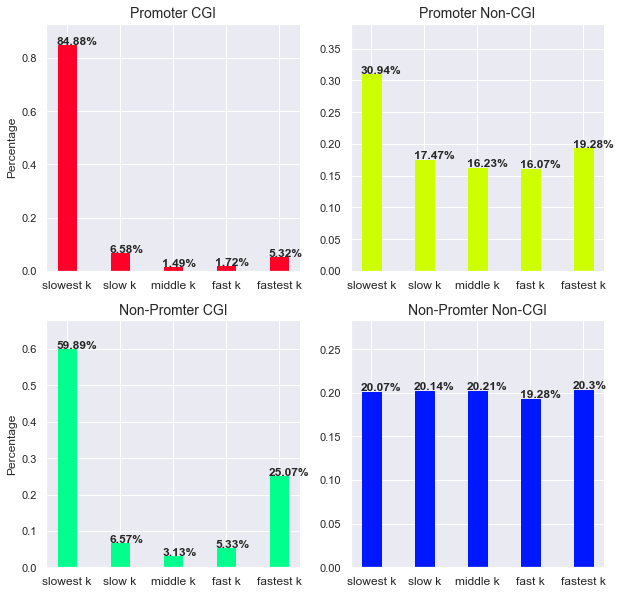

In [8]:
plot_K_in_promoter_or_CGI_context()

In [28]:
def plot_K_hist_in_different_markers(BASE_DIR, SUB_DIR_NAME):
    K_fp = os.path.join(ORIGIN_DATA_DIR, "Rep55", "tile_2.csv")
    k_col_index = 2
    percs = []
    df = pd.read_csv(K_fp, sep=',', header=None).values

    ks = df[:, k_col_index]
    ks[ks <= 0] = 0.001
    ks = np.log10(ks)
    df[:, k_col_index] = ks

    percentiles = [-2.0]
    percentile_names = []
    for i in range(1, N_CLASSES + 1):
        percentile = i * 20
        percentile_names.append(str(percentile))
        percentiles.append(float(np.percentile(ks, percentile)))
    percs.append(percentiles[1:])

    df_indexs_arr = []
    for p_idx in range(0, N_CLASSES):
        df_indexs = np.logical_and(ks > percentiles[p_idx], ks < percentiles[p_idx + 1])
        df_indexs_arr.append(df_indexs)
    ind = np.arange(len(CLASS_LABELS))
    cm = plt.get_cmap('gist_rainbow')
    input_fps = []
    file_names = []
    for file_name in os.listdir(BASE_DIR):
        if file_name.endswith(".csv"):
            input_fps.append(os.path.join(BASE_DIR, file_name))
            file_names.append(file_name.strip(".csv"))
    N_FILES = len(input_fps)
    N_COL = 5
    Max_NROW = 3
    N_SUBFIG_PER_FIG = Max_NROW * N_COL
    NFIG = int(math.ceil(N_FILES / N_SUBFIG_PER_FIG))
    fig_dir = os.path.join(FIGURE_DIR, SUB_DIR_NAME)
    if not os.path.exists(fig_dir):
        os.makedirs(fig_dir)
    for i in range(NFIG):
        if NFIG > 1:
            fig_fp = os.path.join(fig_dir, SUB_DIR_NAME + "_" + str(i) + ".png")
        else:
            fig_fp = os.path.join(fig_dir, SUB_DIR_NAME + ".png")
        base_index = i * N_SUBFIG_PER_FIG
        N_remaining_files = N_FILES - base_index
        N_ROW = int(math.ceil((N_remaining_files) / N_COL)) if N_remaining_files <= N_SUBFIG_PER_FIG else Max_NROW
        
        fig, axs = plt.subplots(N_ROW, N_COL, figsize=(N_COL * EACH_SUB_FIG_SIZE, N_ROW * EACH_SUB_FIG_SIZE))
        SUB_FIG_RANGE = N_SUBFIG_PER_FIG if N_remaining_files > N_SUBFIG_PER_FIG else N_remaining_files

        for j in range(SUB_FIG_RANGE):
            row = j // N_COL
            col = j % N_COL
            if N_ROW == 1:
                ax = axs[col]
            else:
                ax = axs[row][col]
            index = base_index + j
            class_fp = input_fps[index]
            categories = pd.read_csv(class_fp, sep="\t", header=None).values
            class_data = []
            cat_indexs = categories[:, -1] == 1
            for cid, class_label in enumerate(CLASS_LABELS):
                df_indexs = df_indexs_arr[cid]
                intersect = np.logical_and(df_indexs, cat_indexs)
                # int_data = df[intersect]
                cls_count = np.sum(categories[intersect, -1])
                class_data.append(cls_count)
            class_data=np.array(class_data)
            class_data = class_data[:] / np.sum(class_data)
            y_max = np.max(class_data) + 0.08
            pl = ax.bar(ind, tuple(list(class_data)), 0.35)
            for item in pl:
                item.set_color(cm(1. * j / SUB_FIG_RANGE))
            for cid, class_label in enumerate(CLASS_LABELS):
                ax.text(ind[cid] - 0.2, class_data[cid] + 0.002,
                        str(round(class_data[cid] * 100.0, 2)) + "%", fontsize=12, weight="bold")
            if col == 0:
                ax.set_ylabel("Percentage", fontsize=18)
            ax.set_xticks(ind)
            ax.set_xticklabels(CLASS_LABELS, fontsize=12)
            ax.set_xlim(-0.5, len(CLASS_LABELS)-0.5)
            ax.set_ylim(0, y_max)
            ax.set_title(file_names[index], fontsize=18)
        plt.savefig(fig_fp, dpi=200)

In [ ]:
REGION="Histone_Modification_Enzyme"
plot_K_hist_in_different_markers(os.path.join(GENOMIC_FEATURES_DIR, REGION, "K_intersected"),REGION)